In [1]:

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the RDS file
readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Library/Cloudstorage/Dropbox/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp import *
from fig5utils import *
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DO the analysis with data stopped at enrollment

In [5]:

# Load and initialize model:
Y, E, G, essentials = load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/')
# When initializing the model:
original_G = G # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_clusters_400k.pt')
# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

Loading components...


/Users/sarahurbut/aladynoulli2/pyScripts/fig5utils.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/Users/sarahurbut/aladynoul

Loaded all components successfully!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81263/159635465.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/Li

In [7]:
# Example calls:
from fig5utils import *
checkpoint_path = '/Users/sarahurbut/Library/Cloudstorage/Dropbox/enrollment_model_W0.0001_jointphi_sexspecific.pt'
#checkpoint_path = '/Users/sarahurbut/Library/Cloudstorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt'
checkpoint = torch.load(checkpoint_path)


Y_100k, E_100k, G_100k, indices = subset_data(Y,E,G, start_index=0, end_index=10000)
G_100k=checkpoint['G']
torch.manual_seed(42)
np.random.seed(42)
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/Cloudstorage/Dropbox/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_sd_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
model.load_state_dict(checkpoint['model_state_dict'])
model.G.shape

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81263/3324335180.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
/var


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0008,  0.0071,  0.0117,  0.0152, -0.0106])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered

torch.Size([10000, 37])

In [8]:
# Calculate bootstrap results
from fig5utils import *
# static model saving 
aladynoulli_results_boot = evaluate_major_diseases_wsex_with_bootstrap(model, Y_100k, E_100k, model.disease_names, pce_df, n_bootstraps=20, follow_up_duration_years=10)
# 6. Evaluate Baseline Models on TEST data <-- UNCOMMENT THIS



Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC: 0.712 (0.693-0.724) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

   Sex-stratified analysis:
   Female: AUC = 0.668, Events = 273/5409
   Male: AUC = 0.701, Events = 558/4591

   ASCVD risk in patients with pre-existing conditions:
   RA: AUC = 0.681, Events = 8/37
   Breast_Cancer: AUC = 0.630, Events = 13/170

Evaluating Diabetes (10-Year Outcome, 1-Year Score)...
AUC: 0.622 (0.606-0.636) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

   Sex-stratified analysis:
   Female: AUC = 0.611, Events = 264/5409
   Male: AUC = 0.624, Events = 317/4591

Evaluating Atrial_Fib (10-Year Outcome, 1-Year Score)...
AUC: 0.684 (0.657-0.707) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 10000 individuals)
Excluded 13


ROC AUC Comparison (10-year prediction from enrollment):
Our model: 0.712
PREVENT: 0.653


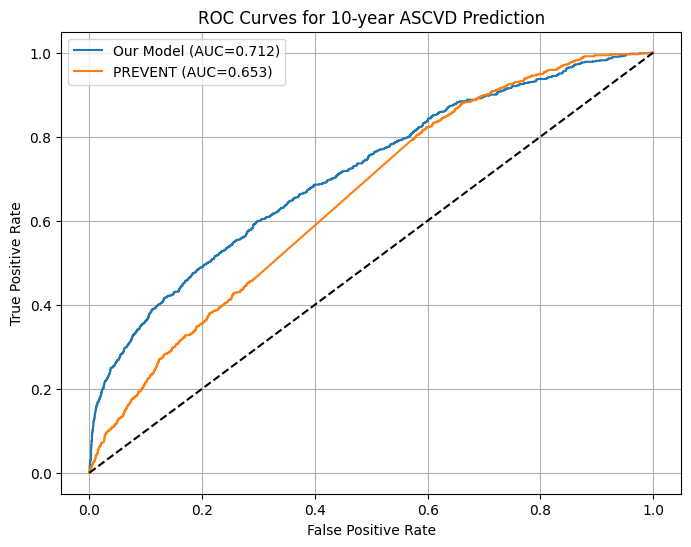

In [9]:
compare_with_prevent(model, pce_df, [111, 112, 113, 114, 115, 116])

In [10]:
from fig5utils import *
# 1. Define Train Indices 
train_indices = np.arange(20000, 30000) # Example

# 2. Define Test Data (using Y_100k and FH_processed subset aligned to it)
Y_test_eval = Y_100k 
fh_processed=pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox/baselinagefamh.csv')
FH_test_eval = fh_processed.iloc[0:10000] # Make sure FH_test_eval aligns with Y_100k


# 3. Set Follow-up duration
follow_up = 10

fitted_models = fit_cox_baseline_models(
    Y_full=Y,  # Your full Y tensor
    FH_processed=fh_processed,  # Your processed family history DataFrame
    train_indices=np.arange(20000, 30000),  # Training indices
    disease_mapping=disease_mapping,  # Dictionary mapping disease groups to FH columns
    major_diseases=major_diseases,  # Dictionary of disease groups and their names
    disease_names=model.disease_names,  # List of all disease names
    follow_up_duration_years=10  # Optional: follow-up duration in years
)


Fitting Cox models using training indices [20000:30000]...
 - Fitting ASCVD...
   Model fitted for ASCVD using 20000 samples.
 - Fitting Diabetes...
   Model fitted for Diabetes using 20000 samples.
 - Atrial_Fib: No FH columns, fitting Sex only.
 - Fitting Atrial_Fib...
   Model fitted for Atrial_Fib using 9877 samples.
   Excluded 123 prevalent cases for Atrial_Fib.
 - CKD: No FH columns, fitting Sex only.
 - Fitting CKD...
   Model fitted for CKD using 9989 samples.
   Excluded 11 prevalent cases for CKD.
 - All_Cancers: No FH columns, fitting Sex only.
 - Fitting All_Cancers...
   Model fitted for All_Cancers using 30000 samples.
 - Fitting Stroke...
   Model fitted for Stroke using 9978 samples.
   Excluded 22 prevalent cases for Stroke.
 - Fitting Heart_Failure...
   Model fitted for Heart_Failure using 9987 samples.
   Excluded 13 prevalent cases for Heart_Failure.
 - Pneumonia: No FH columns, fitting Sex only.
 - Fitting Pneumonia...
   Model fitted for Pneumonia using 30000 sa

In [12]:
cox_results_auc = evaluate_cox_baseline_models_auc(
    fitted_models=fitted_models,
    Y_test=Y_100k,
    FH_test=fh_processed.iloc[0:10000],
    disease_mapping=disease_mapping,
    major_diseases=major_diseases,
    disease_names=model.disease_names,
    follow_up_duration_years=10
)


Evaluating Cox models on test data (10-year AUC)...
 - Evaluating ASCVD...
   10-year AUC: 0.684 (0.662-0.702) | Events: 530/10000
 - Evaluating Diabetes...
   10-year AUC: 0.645 (0.621-0.665) | Events: 581/10000
 - Evaluating Atrial_Fib...
   10-year AUC: 0.712 (0.691-0.735) | Events: 376/10000
 - Evaluating CKD...
   10-year AUC: 0.699 (0.655-0.748) | Events: 104/10000
 - Evaluating All_Cancers...
   10-year AUC: 0.713 (0.683-0.737) | Events: 319/10000
 - Evaluating Stroke...
   10-year AUC: 0.647 (0.560-0.729) | Events: 49/10000
 - Evaluating Heart_Failure...
   10-year AUC: 0.769 (0.720-0.811) | Events: 84/10000
 - Evaluating Pneumonia...
   10-year AUC: 0.687 (0.662-0.713) | Events: 335/10000
 - Evaluating COPD...
   10-year AUC: 0.652 (0.621-0.683) | Events: 272/10000
 - Evaluating Osteoporosis...
   10-year AUC: 0.736 (0.696-0.772) | Events: 219/10000
 - Evaluating Anemia...
   10-year AUC: 0.568 (0.532-0.602) | Events: 272/10000
 - Evaluating Colorectal_Cancer...
   10-year AU

In [39]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = aladynoulli_results_boot[disease]
    cox = cox_results_auc.get(disease, {})
    
    row = {
        'Disease': disease,
        'Aladynoulli_AUC': f"{aladyn['auc']:.3f} ({aladyn['ci_lower']:.3f}-{aladyn['ci_upper']:.3f})",
        'Cox_AUC': f"{cox.get('auc', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('auc') is not None else "N/A",
        'Events': aladyn['n_events'],
        'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_bootstatic_auc.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease     Aladynoulli_AUC             Cox_AUC  Events Rate
               ASCVD 0.712 (0.693-0.724) 0.684 (0.662-0.702)     831 8.3%
              Asthma 0.511 (0.485-0.532) 0.499 (0.476-0.518)     606 6.1%
            Diabetes 0.622 (0.606-0.636) 0.645 (0.621-0.665)     581 5.8%
              Anemia 0.593 (0.577-0.613) 0.568 (0.532-0.602)     523 5.2%
         All_Cancers 0.680 (0.664-0.699) 0.713 (0.683-0.737)     480 4.8%
   Thyroid_Disorders 0.579 (0.561-0.601) 0.634 (0.609-0.661)     479 4.8%
          Depression 0.470 (0.449-0.498) 0.474 (0.441-0.497)     405 4.0%
                COPD 0.646 (0.616-0.666) 0.652 (0.621-0.683)     394 3.9%
          Atrial_Fib 0.684 (0.657-0.707) 0.712 (0.691-0.735)     376 3.8%
           Pneumonia 0.683 (0.663-0.708) 0.687 (0.662-0.713)     335 3.4%
    Secondary_Cancer 0.607 (0.585-0.636) 0.630 (0.602-0.67

In [15]:
from fig5utils import *
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message="DataFrame Index is not unique")
cox_results_c=evaluate_cox_baseline_models(
    fitted_models=fitted_models,
    Y_test=Y_100k,
    FH_test=fh_processed.iloc[0:10000],
    disease_mapping=disease_mapping,
    major_diseases=major_diseases,
    disease_names=model.disease_names,
    follow_up_duration_years=10
)


Evaluating Cox models on test data...
 - Evaluating ASCVD...
   Overall C-index: 0.650 (0.629-0.666)
   Events: 708/20000

   Sex-stratified analysis:
   Female: C-index = 0.519, Events = 195/10818
   Male: C-index = 0.541, Events = 513/9182

   ASCVD risk in patients with pre-existing conditions:
   RA: C-index = 0.824, Events = 3/74
   Breast_Cancer: C-index = 0.411, Events = 6/340
 - Evaluating Diabetes...
   Overall C-index: 0.606 (0.586-0.628)
   Events: 598/20000

   Sex-stratified analysis:
   Female: C-index = 0.591, Events = 271/10818
   Male: C-index = 0.562, Events = 327/9182
 - Evaluating Atrial_Fib...
   Overall C-index: 0.584 (0.558-0.612)
   Events: 376/9864
   Excluded 136 prevalent cases for Atrial_Fib.

   Sex-stratified analysis:
   Female: C-index = 0.500, Events = 139/5372
   Male: C-index = 0.500, Events = 237/4492
 - Evaluating CKD...
   Overall C-index: 0.555 (0.491-0.598)
   Events: 104/9980
   Excluded 20 prevalent cases for CKD.

   Sex-stratified analysis:


In [38]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = aladynoulli_results_boot[disease]
    cox = cox_results_c.get(disease, {})
    
    row = {
        'Disease': disease,
        'Aladynoulli_AUC': f"{aladyn['auc']:.3f} ({aladyn['ci_lower']:.3f}-{aladyn['ci_upper']:.3f})",
        'Cox_Concordance': f"{cox.get('c_index', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('c_index') is not None else "N/A",
        'Events': aladyn['n_events'],
        'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_cindex.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease     Aladynoulli_AUC     Cox_Concordance  Events Rate
               ASCVD 0.712 (0.693-0.724) 0.650 (0.629-0.666)     831 8.3%
              Asthma 0.511 (0.485-0.532) 0.520 (0.503-0.543)     606 6.1%
            Diabetes 0.622 (0.606-0.636) 0.606 (0.586-0.628)     581 5.8%
              Anemia 0.593 (0.577-0.613) 0.549 (0.511-0.574)     523 5.2%
         All_Cancers 0.680 (0.664-0.699) 0.615 (0.588-0.645)     480 4.8%
   Thyroid_Disorders 0.579 (0.561-0.601) 0.649 (0.629-0.667)     479 4.8%
          Depression 0.470 (0.449-0.498) 0.559 (0.539-0.584)     405 4.0%
                COPD 0.646 (0.616-0.666) 0.535 (0.509-0.566)     394 3.9%
          Atrial_Fib 0.684 (0.657-0.707) 0.584 (0.558-0.612)     376 3.8%
           Pneumonia 0.683 (0.663-0.708) 0.561 (0.536-0.587)     335 3.4%
    Secondary_Cancer 0.607 (0.585-0.636) 0.474 (0.438-0.51

In [36]:
# Get indices for RA and Breast Cancer
from fig5utils import *

disease_names=model.disease_names
ra_patients = get_preexisting_patient_indices(Y_100k, pce_df, disease_names, 'Rheumatoid_Arthritis')
bc_patients = get_preexisting_patient_indices(Y_100k, pce_df, disease_names, 'Breast_Cancer')

# PCE/PREVENT AUC for the same patients
auc_pce_ra, auc_prevent_ra = pce_prevent_auc_for_preexisting(Y_100k, pce_df, ra_patients, disease_names)
auc_pce_bc, auc_prevent_bc = pce_prevent_auc_for_preexisting(Y_100k, pce_df, bc_patients, disease_names)

PCE AUC: 0.690, PREVENT AUC: 0.659
PCE AUC: 0.528, PREVENT AUC: 0.544


Dynamic results

In [18]:
# use ernollment tested model to make projections forward
checkpoint_path = '/Users/sarahurbut/Library/Cloudstorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt'
c=torch.load(checkpoint_path)
model.load_state_dict(c['model_state_dict'])
dynamic_bootstrap_results = evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, Y_100k, E_100k, model.disease_names, pce_df, n_bootstraps=20, follow_up_duration_years=10)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81263/1686319557.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  c=torch.load(checkpoint_path)



Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.875 (0.866-0.884) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.741 (0.722-0.764) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.775 (0.758-0.801) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.751 (0.720-0.779) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 207 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.765 (0.748-0.782) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 480 (4

In [19]:
# For RA
from fig5utils import *
disease_names = model.disease_names
ra_results = dynamic_aladynoulli_auc_for_preexisting(model, Y_100k, E_100k, disease_names, pce_df, 'Rheumatoid_Arthritis')
# For Breast Cancer
bc_results = dynamic_aladynoulli_auc_for_preexisting(model, Y_100k, E_100k, disease_names, pce_df, 'Breast_Cancer')



Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.841 (0.632-1.000) (calculated on 37 individuals)
Events (10-Year in Eval Cohort): 8 (21.6%) (from 37 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.602 (0.296-0.877) (calculated on 37 individuals)
Events (10-Year in Eval Cohort): 6 (16.2%) (from 37 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.845 (0.681-0.966) (calculated on 36 individuals)
Events (10-Year in Eval Cohort): 5 (13.9%) (from 36 individuals)
Excluded 1 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.833 (0.622-1.000) (calculated on 37 individuals)
Events (10-Year in Eval Cohort): 3 (8.1%) (from 37 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.278 (0.160-0.433) (calculated on 37 individuals)
Events (10-Year in Eval Cohort): 1 (2.7%) (from 37 individuals)
Exclude

In [37]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = dynamic_bootstrap_results[disease]
    cox = cox_results_auc.get(disease, {})
    
    row = {
        'Disease': disease,
        'Aladynoulli_AUC': f"{aladyn['auc']:.3f} ({aladyn['ci_lower']:.3f}-{aladyn['ci_upper']:.3f})",
        'Cox_AUC': f"{cox.get('auc', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('auc') is not None else "N/A",
        'Events': aladyn['n_events'],
        'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_dynamic.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease     Aladynoulli_AUC             Cox_AUC  Events Rate
               ASCVD 0.875 (0.866-0.884) 0.684 (0.662-0.702)     831 8.3%
              Asthma 0.691 (0.655-0.720) 0.499 (0.476-0.518)     606 6.3%
            Diabetes 0.741 (0.722-0.764) 0.645 (0.621-0.665)     581 5.8%
              Anemia 0.719 (0.698-0.746) 0.568 (0.532-0.602)     523 5.2%
         All_Cancers 0.765 (0.748-0.782) 0.713 (0.683-0.737)     480 4.8%
   Thyroid_Disorders 0.709 (0.678-0.730) 0.634 (0.609-0.661)     479 4.8%
          Depression 0.673 (0.656-0.704) 0.474 (0.441-0.497)     405 4.1%
                COPD 0.760 (0.731-0.780) 0.652 (0.621-0.683)     394 3.9%
          Atrial_Fib 0.775 (0.758-0.801) 0.712 (0.691-0.735)     376 3.8%
           Pneumonia 0.784 (0.767-0.814) 0.687 (0.662-0.713)     335 3.4%
    Secondary_Cancer 0.715 (0.666-0.744) 0.630 (0.602-0.67

# compare cox with noulli added 

In [21]:

# Load and initialize model:
Y, E, G, essentials = load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/')
# When initializing the model:
original_G = G # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_clusters_400k.pt')
# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_sd_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters

train_indices=np.arange(20000, 30000)
FH_train = fh_processed.iloc[train_indices].reset_index(drop=True)
FH_train.shape
FH_train.tail()
# Load the model
model_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/resultsenrollAWS/results/output_20000_30000/model.pt'
model.load_state_dict(torch.load(model_path)['model_state_dict'])

# Get predictions (pi) from the model
with torch.no_grad():
    pi, _, _ = model.forward()  # pi shape: (N, D, T)

# For each subject, get their enrollment age (from your covariate DataFrame)
# Suppose FH_train is your DataFrame for the training set (reset index to match order)
aladynoulli_1yr_risk_train = []
for i, row in FH_train.iterrows():
    enroll_time = int(row['age'] - 30)
    # Choose the disease indices you want (e.g., ASCVD indices)
    # For a single disease: d_idx = ...
    # For a group: d_indices = [...]
    # Example for ASCVD:
    d_indices = [111, 112, 113, 114, 115, 116]  # adjust as needed
    if enroll_time < 0 or enroll_time >= pi.shape[2]:
        aladynoulli_1yr_risk_train.append(np.nan)
        continue
    # 1-year risk for ASCVD group at enrollment
    pi_diseases = pi[i, d_indices, enroll_time]
    yearly_risk = 1 - torch.prod(1 - pi_diseases)
    aladynoulli_1yr_risk_train.append(yearly_risk.item())

aladynoulli_1yr_risk_train = np.array(aladynoulli_1yr_risk_train)

batch_start = 20000
batch_end = 30000

# Slice your data for the batch
Y_batch = Y[batch_start:batch_end]
FH_batch = fh_processed.iloc[batch_start:batch_end].reset_index(drop=True)
aladynoulli_1yr_risk_batch = aladynoulli_1yr_risk_train  # Should already be length 10,000

# Indices are now 0-based for this batch
relative_train_indices = np.arange(0, batch_end - batch_start)
train_indices=np.arange(20000, 30000)

# Fit the Cox model with Aladynoulli 1-year risk as covariate
fitted_models = fit_cox_baseline_models_with_aladynoulli(
    Y_batch,
    FH_batch,
    aladynoulli_1yr_risk_batch,
    train_indices=relative_train_indices,
    disease_mapping=disease_mapping,
    major_diseases=major_diseases,
    disease_names=disease_names,
    follow_up_duration_years=10
)

Loading components...


/Users/sarahurbut/aladynoulli2/pyScripts/fig5utils.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/Users/sarahurbut/aladynoul

Loaded all components successfully!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81263/1855198114.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/L


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0009,  0.0069,  0.0118,  0.0153, -0.0106])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81263/1855198114.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

Fitting Cox models (with Aladynoulli 1-year risk) using training indices [0:10000]...
 - Fitting ASCVD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for ASCVD using 20000 samples.
 - Fitting Diabetes...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Diabetes using 20000 samples.
 - Fitting Atrial_Fib...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Atrial_Fib using 9877 samples.
   Excluded 123 prevalent cases for Atrial_Fib.
 - Fitting CKD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for CKD using 9989 samples.
   Excluded 11 prevalent cases for CKD.
 - Fitting All_Cancers...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for All_Cancers using 30000 samples.
 - Fitting Stroke...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Stroke using 9978 samples.
   Excluded 22 prevalent cases for Stroke.
 - Fitting Heart_Failure...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Heart_Failure using 9987 samples.
   Excluded 13 prevalent cases for Heart_Failure.
 - Fitting Pneumonia...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Pneumonia using 30000 samples.
 - Fitting COPD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for COPD using 9971 samples.
   Excluded 29 prevalent cases for COPD.
 - Fitting Osteoporosis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Osteoporosis using 9976 samples.
   Excluded 24 prevalent cases for Osteoporosis.
 - Fitting Anemia...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Anemia using 9937 samples.
   Excluded 63 prevalent cases for Anemia.
 - Fitting Colorectal_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Colorectal_Cancer using 9975 samples.
   Excluded 25 prevalent cases for Colorectal_Cancer.
 - Fitting Breast_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Breast_Cancer using 5356 samples.
   Excluded 39 prevalent cases for Breast_Cancer.
 - Fitting Prostate_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Prostate_Cancer using 4554 samples.
   Excluded 51 prevalent cases for Prostate_Cancer.
 - Fitting Lung_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Lung_Cancer using 9996 samples.
   Excluded 4 prevalent cases for Lung_Cancer.
 - Fitting Bladder_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Bladder_Cancer using 9979 samples.
   Excluded 21 prevalent cases for Bladder_Cancer.
 - Fitting Secondary_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Secondary_Cancer using 30000 samples.
 - Fitting Depression...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Depression using 9918 samples.
   Excluded 82 prevalent cases for Depression.
 - Fitting Anxiety...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Anxiety using 9979 samples.
   Excluded 21 prevalent cases for Anxiety.
 - Fitting Bipolar_Disorder...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Bipolar_Disorder using 9985 samples.
   Excluded 15 prevalent cases for Bipolar_Disorder.
 - Fitting Rheumatoid_Arthritis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Rheumatoid_Arthritis using 9950 samples.
   Excluded 50 prevalent cases for Rheumatoid_Arthritis.
 - Fitting Psoriasis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Psoriasis using 9982 samples.
   Excluded 18 prevalent cases for Psoriasis.
 - Fitting Ulcerative_Colitis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Ulcerative_Colitis using 9949 samples.
   Excluded 51 prevalent cases for Ulcerative_Colitis.
 - Fitting Crohns_Disease...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Crohns_Disease using 9971 samples.
   Excluded 29 prevalent cases for Crohns_Disease.
 - Fitting Asthma...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Asthma using 9694 samples.
   Excluded 306 prevalent cases for Asthma.
 - Fitting Parkinsons...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Parkinsons using 9996 samples.
   Excluded 4 prevalent cases for Parkinsons.
 - Fitting Multiple_Sclerosis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   Model fitted for Multiple_Sclerosis using 9970 samples.
   Excluded 30 prevalent cases for Multiple_Sclerosis.
 - Fitting Thyroid_Disorders...
   Model fitted for Thyroid_Disorders using 9873 samples.
   Excluded 127 prevalent cases for Thyroid_Disorders.
Finished fitting Cox models (with Aladynoulli 1-year risk).


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [ ]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = dynamic_bootstrap_results[disease]
    cox = cox_results_auc.get(disease, {})
    
    row = {
        'Disease': disease,
        'Aladynoulli_AUC': f"{aladyn['auc']:.3f} ({aladyn['ci_lower']:.3f}-{aladyn['ci_upper']:.3f})",
        'Cox_AUC': f"{cox.get('auc', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('auc') is not None else "N/A",
        'Events': aladyn['n_events'],
        'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_dynamic.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease     Aladynoulli_AUC             Cox_AUC  Events Rate
               ASCVD 0.875 (0.866-0.884) 0.684 (0.662-0.702)     831 8.3%
              Asthma 0.691 (0.655-0.720) 0.499 (0.476-0.518)     606 6.3%
            Diabetes 0.741 (0.722-0.764) 0.645 (0.621-0.665)     581 5.8%
              Anemia 0.719 (0.698-0.746) 0.568 (0.532-0.602)     523 5.2%
         All_Cancers 0.765 (0.748-0.782) 0.713 (0.683-0.737)     480 4.8%
   Thyroid_Disorders 0.709 (0.678-0.730) 0.634 (0.609-0.661)     479 4.8%
          Depression 0.673 (0.656-0.704) 0.474 (0.441-0.497)     405 4.1%
                COPD 0.760 (0.731-0.780) 0.652 (0.621-0.683)     394 3.9%
          Atrial_Fib 0.775 (0.758-0.801) 0.712 (0.691-0.735)     376 3.8%
           Pneumonia 0.784 (0.767-0.814) 0.687 (0.662-0.713)     335 3.4%
    Secondary_Cancer 0.715 (0.666-0.744) 0.630 (0.602-0.67

In [ ]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = dynamic_bootstrap_results[disease]
    cox = cox_results_auc.get(disease, {})
    
    row = {
        'Disease': disease,
        'Aladynoulli_AUC': f"{aladyn['auc']:.3f} ({aladyn['ci_lower']:.3f}-{aladyn['ci_upper']:.3f})",
        'Cox_AUC': f"{cox.get('auc', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('auc') is not None else "N/A",
        'Events': aladyn['n_events'],
        'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_dynamic.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease     Aladynoulli_AUC             Cox_AUC  Events Rate
               ASCVD 0.875 (0.866-0.884) 0.684 (0.662-0.702)     831 8.3%
              Asthma 0.691 (0.655-0.720) 0.499 (0.476-0.518)     606 6.3%
            Diabetes 0.741 (0.722-0.764) 0.645 (0.621-0.665)     581 5.8%
              Anemia 0.719 (0.698-0.746) 0.568 (0.532-0.602)     523 5.2%
         All_Cancers 0.765 (0.748-0.782) 0.713 (0.683-0.737)     480 4.8%
   Thyroid_Disorders 0.709 (0.678-0.730) 0.634 (0.609-0.661)     479 4.8%
          Depression 0.673 (0.656-0.704) 0.474 (0.441-0.497)     405 4.1%
                COPD 0.760 (0.731-0.780) 0.652 (0.621-0.683)     394 3.9%
          Atrial_Fib 0.775 (0.758-0.801) 0.712 (0.691-0.735)     376 3.8%
           Pneumonia 0.784 (0.767-0.814) 0.687 (0.662-0.713)     335 3.4%
    Secondary_Cancer 0.715 (0.666-0.744) 0.630 (0.602-0.67

In [22]:
model_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/resultsenrollAWS/results/output_10000_20000/model.pt'
model.load_state_dict(torch.load(model_path)['model_state_dict'])

# Get predictions (pi) from the model
with torch.no_grad():
    pi, _, _ = model.forward()  # pi shape: (N, D, T)

# For each subject, get their enrollment age (from your covariate DataFrame)
# Suppose FH_train is your DataFrame for the training set (reset index to match order)
aladynoulli_1yr_risk_test = []
for i, row in FH_train.iterrows():
    enroll_time = int(row['age'] - 30)
    # Choose the disease indices you want (e.g., ASCVD indices)
    # For a single disease: d_idx = ...
    # For a group: d_indices = [...]
    # Example for ASCVD:
    d_indices = [111, 112, 113, 114, 115, 116]  # adjust as needed
    if enroll_time < 0 or enroll_time >= pi.shape[2]:
        aladynoulli_1yr_risk_train.append(np.nan)
        continue
    # 1-year risk for ASCVD group at enrollment
    pi_diseases = pi[i, d_indices, enroll_time]
    yearly_risk = 1 - torch.prod(1 - pi_diseases)
    aladynoulli_1yr_risk_test.append(yearly_risk.item())

aladynoulli_1yr_risk_test = np.array(aladynoulli_1yr_risk_test)
aladynoulli_1yr_risk_test.shape

from fig5utils import *
test_start = 0
test_end = 10000

Y_test = Y[test_start:test_end]
FH_test = fh_processed.iloc[test_start:test_end].reset_index(drop=True)
   # If you have Aladynoulli 1-year risk for the test set, use:
aladynoulli_1yr_risk_test = aladynoulli_1yr_risk_test  # Should be length 10,000, one per patient in this batch

results = evaluate_cox_baseline_models_auc_with_aladynoulli(
    fitted_models,
    Y_test,
    FH_test,
    disease_mapping,
    major_diseases,
    disease_names,
    aladynoulli_1yr_risk_test,
    follow_up_duration_years=10,
    n_bootstraps=100
)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81263/2263753070.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)[


Evaluating Cox models (with Aladynoulli 1-year risk as covariate, 10-year AUC)...
 - Evaluating ASCVD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.661 (0.641-0.682) | Events: 530/10000
 - Evaluating Diabetes...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.598 (0.578-0.624) | Events: 581/10000
 - Evaluating Atrial_Fib...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.593 (0.567-0.627) | Events: 376/10000
 - Evaluating CKD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.546 (0.501-0.598) | Events: 104/10000
 - Evaluating All_Cancers...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.640 (0.612-0.666) | Events: 319/10000
 - Evaluating Stroke...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.583 (0.514-0.654) | Events: 49/10000
 - Evaluating Heart_Failure...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.610 (0.549-0.672) | Events: 84/10000
 - Evaluating Pneumonia...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.579 (0.549-0.608) | Events: 335/10000
 - Evaluating COPD...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.535 (0.511-0.567) | Events: 272/10000
 - Evaluating Osteoporosis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.649 (0.622-0.678) | Events: 219/10000
 - Evaluating Anemia...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.515 (0.479-0.549) | Events: 272/10000
 - Evaluating Colorectal_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.570 (0.511-0.623) | Events: 75/10000
 - Evaluating Breast_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.508 (0.437-0.604) | Events: 42/5409
 - Evaluating Prostate_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.514 (0.471-0.560) | Events: 204/4591
 - Evaluating Lung_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.554 (0.479-0.619) | Events: 75/10000
 - Evaluating Bladder_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.737 (0.690-0.784) | Events: 49/10000
 - Evaluating Secondary_Cancer...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.564 (0.520-0.611) | Events: 154/10000
 - Evaluating Depression...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.554 (0.525-0.585) | Events: 405/10000
 - Evaluating Anxiety...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.555 (0.520-0.597) | Events: 241/10000
 - Evaluating Bipolar_Disorder...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.609 (0.522-0.680) | Events: 34/10000
 - Evaluating Rheumatoid_Arthritis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.552 (0.491-0.599) | Events: 123/10000
 - Evaluating Psoriasis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.558 (0.490-0.635) | Events: 40/10000
 - Evaluating Ulcerative_Colitis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.566 (0.482-0.651) | Events: 50/10000
 - Evaluating Crohns_Disease...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.558 (0.459-0.650) | Events: 31/10000
 - Evaluating Asthma...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.532 (0.508-0.554) | Events: 606/10000
 - Evaluating Parkinsons...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.536 (0.444-0.634) | Events: 46/10000
 - Evaluating Multiple_Sclerosis...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.685 (0.612-0.778) | Events: 21/10000
 - Evaluating Thyroid_Disorders...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['aladynoulli_1yr'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


   10-year AUC (Cox+Aladynoulli 1yr): 0.641 (0.619-0.666) | Events: 424/10000
Finished evaluating Cox models (with Aladynoulli 1-year risk, 10-year AUC).


In [45]:
import pandas as pd

# Create DataFrame from both results
df_compare = []
for disease in aladynoulli_results_boot.keys():
    aladyn = results[disease]
    cox = cox_results_auc.get(disease, {})
    
    row = {
        'Disease': disease,
       'Cox_Aladyn_AUC': f"{aladyn.get('auc', np.nan):.3f} ({aladyn.get('ci', (np.nan, np.nan))[0]:.3f}-{aladyn.get('ci', (np.nan, np.nan))[1]:.3f})" if aladyn.get('auc') is not None else "N/A",
        'Cox_AUC': f"{cox.get('auc', np.nan):.3f} ({cox.get('ci', (np.nan, np.nan))[0]:.3f}-{cox.get('ci', (np.nan, np.nan))[1]:.3f})" if cox.get('auc') is not None else "N/A",
        'Events': aladyn['n_events']
        #'Rate': f"{aladyn['event_rate']:.1f}%"
    }
    df_compare.append(row)

df_compare = pd.DataFrame(df_compare)

# Sort by number of events descending
df_compare = df_compare.sort_values('Events', ascending=False)

# Save to CSV for R
df_compare.to_csv('model_comparison_results_dynamic.csv', index=False)

# Display nicely formatted table in Python
print("\nModel Comparison Results:")
print("-" * 100)
print(df_compare.to_string(index=False))


Model Comparison Results:
----------------------------------------------------------------------------------------------------
             Disease      Cox_Aladyn_AUC             Cox_AUC  Events
              Asthma 0.532 (0.508-0.554) 0.499 (0.476-0.518)     606
            Diabetes 0.598 (0.578-0.624) 0.645 (0.621-0.665)     581
               ASCVD 0.661 (0.641-0.682) 0.684 (0.662-0.702)     530
   Thyroid_Disorders 0.641 (0.619-0.666) 0.634 (0.609-0.661)     424
          Depression 0.554 (0.525-0.585) 0.474 (0.441-0.497)     405
          Atrial_Fib 0.593 (0.567-0.627) 0.712 (0.691-0.735)     376
           Pneumonia 0.579 (0.549-0.608) 0.687 (0.662-0.713)     335
         All_Cancers 0.640 (0.612-0.666) 0.713 (0.683-0.737)     319
                COPD 0.535 (0.511-0.567) 0.652 (0.621-0.683)     272
              Anemia 0.515 (0.479-0.549) 0.568 (0.532-0.602)     272
             Anxiety 0.555 (0.520-0.597) 0.510 (0.466-0.546)     241
        Osteoporosis 0.649 (0.622-0.678) 0.7